## Neste Projeto de Ciência de Dados, aplicarei um modelo de classificação com Machine Learning, que pode prever a função de um gene com base apenas no sequenciamento de DNA da sequência de codificação.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
human_data = pd.read_table('human_data.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


### Temos alguns dados para regiões de codificação de sequência de DNA humano e um rótulo de classe. Também temos dados para Chimpanzé e uma espécie mais divergente, o cão.

In [3]:
chimp_data = pd.read_table('chimp_data.txt')
dog_data = pd.read_table('dog_data.txt')
chimp_data.head()
dog_data.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


### Vamos definir uma função para coletar todos os possíveis k-mers sobrepostos de um comprimento especificado de qualquer string de sequência.

In [4]:
# função para converter strings de sequência em palavras k-mer, tamanho padrão = 6 (palavras hexamer)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

#### Agora podemos converter nossas sequências de dados de treinamento em k-mers sobrepostos curtos de comprimento 6. Vamos fazer isso para cada espécie de dados que temos usando nossa função getKmers.

In [5]:
human_data['words'] = human_data.apply(lambda x: getKmers(x['sequence']), axis=1)
human_data = human_data.drop('sequence', axis=1)
chimp_data['words'] = chimp_data.apply(lambda x: getKmers(x['sequence']), axis=1)
chimp_data = chimp_data.drop('sequence', axis=1)
dog_data['words'] = dog_data.apply(lambda x: getKmers(x['sequence']), axis=1)
dog_data = dog_data.drop('sequence', axis=1)

#### Agora, nossos dados de sequência de codificação são alterados para letras minúsculas, divididos em todas as palavras k-mer possíveis de comprimento 6 e prontos para a próxima etapa. Vamos dar uma olhada.

In [6]:
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


#### Como vamos usar as ferramentas de processamento de linguagem natural scikit-learn para fazer a contagem de k-mer, precisamos agora converter as listas de k-mers para cada gene em frases de string de palavras que o vetorizador de contagem pode usar. Também podemos fazer uma variável y para conter os rótulos de classe. Vamos fazer isso agora.

In [16]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data.iloc[:, 0].values
#print(human_texts[2])

In [8]:
y_data

array([4, 4, 3, ..., 6, 6, 6], dtype=int64)

#### Faremos os mesmos passos para chimpanzé e cachorro

In [9]:
chimp_texts = list(chimp_data['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_chimp = chimp_data.iloc[:, 0].values                       

dog_texts = list(dog_data['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_dog = dog_data.iloc[:, 0].values

In [10]:
# Criando o modelo Bag of Words usando CountVectorizer()
# Isso é equivalente à contagem de k-mer
# O tamanho n-gram de 4 foi previamente determinado por testes
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


#### Se dermos uma olhada no equilíbrio de classe, podemos ver que temos um conjunto de dados relativamente equilibrado.

<AxesSubplot:>

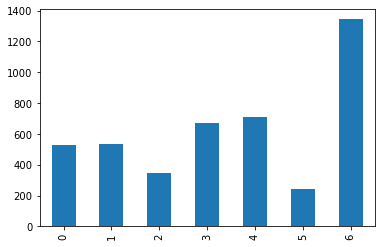

In [11]:
human_data['class'].value_counts().sort_index().plot.bar()

#### Dividindo o conjunto de dados humanos no conjunto de treinamento e conjunto de teste

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size = 0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


In [13]:
# O parâmetro alfa foi determinado pela pesquisa de grade anteriormente

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

### Ok, então vamos ver algumas métricas de desempenho do modelo, como a matriz de confusão, exatidão, precisão, recall e pontuação f1. Estamos obtendo resultados realmente bons em nossos dados não vistos, então parece que nosso modelo não superajustou os dados de treinamento.

In [14]:
y_pred = classifier.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984
